# Create test dataframe

In [1]:
import numpy as np
import pandas as pd
from time import sleep
from os import environ
from data.get_data import DataFactory
from config.config import ConfigFactory
from signals.find_signal import FindSignal
from signal_stat.signal_stat import SignalStat
from indicators.indicators import IndicatorFactory

debug = False
# Set environment variable
environ["ENV"] = "development"
# Set dataframe dict
dfs = {'stat': {'buy': pd.DataFrame(columns=['time', 'ticker', 'timeframe']),
                'sell': pd.DataFrame(columns=['time', 'ticker', 'timeframe'])}}
# Set list of available exchanges, cryptocurrencies and tickers
# exchanges = {'Binance': {'BTCUSDT': ['1h', '5m'], 'ETHUSDT': ['1h', '5m']}}
exchanges = {'Binance': {'ETHUSDT': ['1h', '5m']}}
# Get configs
configs = ConfigFactory.factory(environ).configs
# Get dict of exchange APIs
exchange_apis = dict()
for exchange in exchanges:
    exchange_apis[exchange] = DataFactory.factory(exchange, **configs)
# Higher timeframe from which we take levels
higher_timeframe = configs['Timeframes']['higher_timeframe']
# Counter
i = 1

    
# For every exchange, ticker and timeframe in base get cryptocurrency data and write it to correspond dataframe
for exchange, exchange_api in exchange_apis.items():
    tickers = exchanges[exchange]
    for ticker in tickers:
        timeframes = tickers[ticker]
        for timeframe in timeframes:
            print(f'Cycle number is {i}, exchange is {exchange}, ticker is {ticker}, timeframe is {timeframe}')
            if debug:
                df = pd.read_pickle('BTCUSDT_5m.pkl')
                new_data_flag = True
            else:
                # If cryptocurrency dataframe is in dataframe dict - get it, else - create the new one
                df = dfs.get(ticker, dict()).get(timeframe, dict()).get('data', pd.DataFrame())
                # Write data to the dataframe
                df, new_data_flag = exchange_api.get_data(df, ticker, timeframe)
            if new_data_flag and timeframe != higher_timeframe:
                # Create indicator list from search signal patterns list
                indicators = list()
                indicator_list = configs['Indicator_list']
                for indicator in indicator_list:
                    ind_factory = IndicatorFactory.factory(indicator, configs)
                    if ind_factory:
                        indicators.append(ind_factory)
                # Write indicators to dataframe, update dataframe dict
                dfs, df = exchange_api.add_indicator_data(dfs, df, indicators, ticker, timeframe, configs)
                # Get signal
                fs = FindSignal(configs)
                points = fs.find_signal(df, dfs[ticker][timeframe]['levels'])
                print(points)
                levels = dfs[ticker][timeframe]['levels']
                # Write statistics
                ss = SignalStat()
                dfs = ss.write_stat(dfs, ticker, timeframe, points)
                # print(ss.calculate_total_stat(dfs, 'buy'))
                # print(ss.calculate_total_stat(dfs, 'sell'))
                # print(ss.calculate_ticker_stat(dfs, 'buy', ticker, timeframe))
                # print(ss.calculate_ticker_stat(dfs, 'sell', ticker, timeframe))
                # Save dataframe to the disk
                try:
                    open(f'{ticker}_{timeframe}.pkl', 'w').close()
                except FileNotFoundError:
                    pass
                df.to_pickle(f'{ticker}_{timeframe}.pkl')

Cycle number is 1, exchange is Binance, ticker is ETHUSDT, timeframe is 1h
1000
Cycle number is 1, exchange is Binance, ticker is ETHUSDT, timeframe is 5m
1000
[(141, 'buy'), (297, 'sell'), (298, 'sell'), (712, 'buy'), (845, 'buy'), (846, 'buy')]


## Plot STOCH values

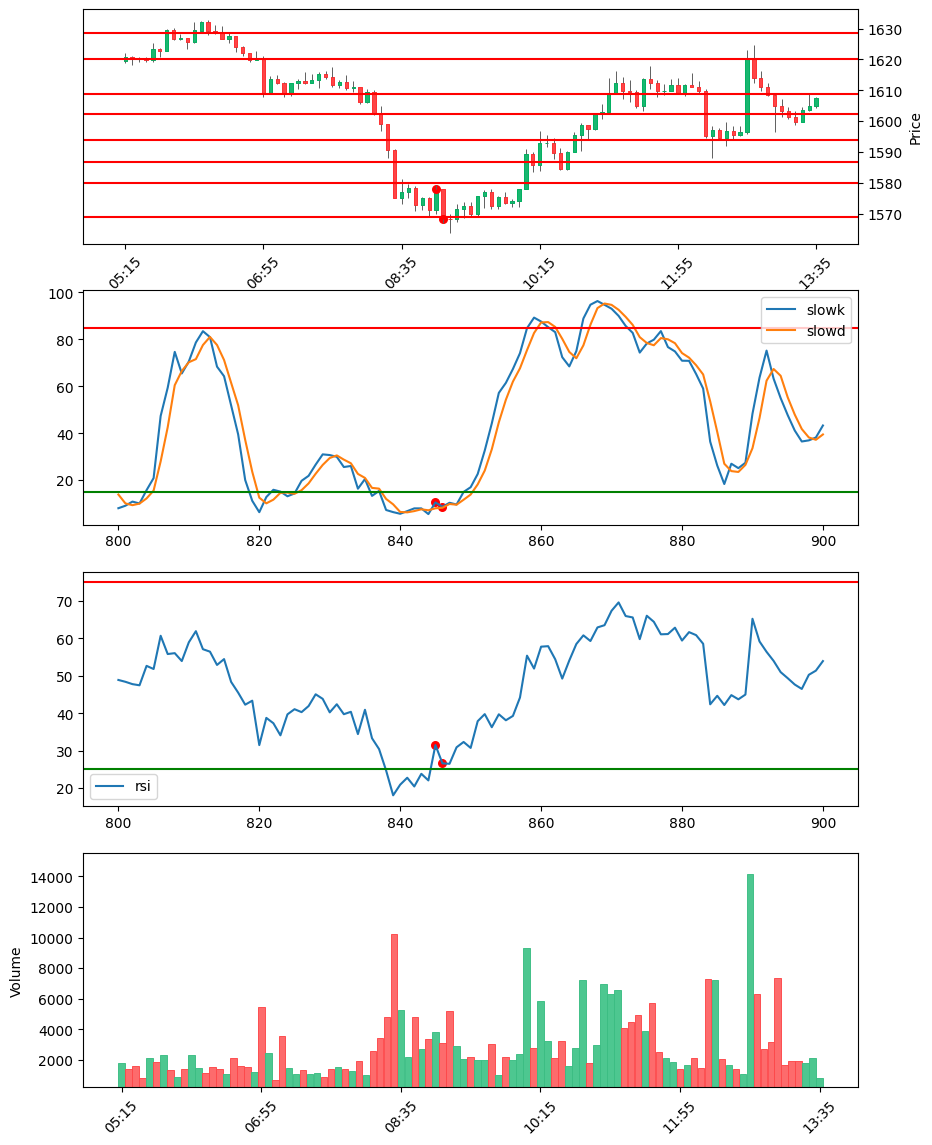

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf

low_bound = 800
high_bound = 900

pd.set_option('display.max_rows', 500)

# subplots for STOCH and RSI
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 14))

# plot candles
ohlc = df.loc[low_bound:high_bound, ['time', 'open', 'high', 'low', 'close', 'volume']]
ohlc = ohlc.set_index('time')
mpf.plot(ohlc, type='candle', ax=ax1, warn_too_much_data=10000, style='yahoo', volume=ax4)

# plot STOCH
ax2.plot(df.loc[low_bound:high_bound, 'stoch_slowk'])
ax2.plot(df.loc[low_bound:high_bound, 'stoch_slowd'])
# show bounders
ax2.axhline(y=15, color='g', linestyle='-')
ax2.axhline(y=85, color='r', linestyle='-')
leg = ax2.legend(['slowk', 'slowd'])

# plot RSI
ax3.plot(df.loc[low_bound:high_bound, 'rsi'])
ax3.axhline(y=25, color='g', linestyle='-')
ax3.axhline(y=75, color='r', linestyle='-')
leg = ax3.legend(['rsi'])

# plot signal points
scatter_candle_points = list()
scatter_stoch_points = list()
scatter_rsi_points = list()

for point in points:
    scatter_candle_points.append((point[0], df.loc[point[0], 'close']))
    scatter_stoch_points.append((point[0], df.loc[point[0], 'stoch_slowk']))
    scatter_rsi_points.append((point[0], df.loc[point[0], 'rsi']))

for point in scatter_candle_points:
    if low_bound < point[0] < high_bound:
        ax1.scatter(point[0]-low_bound, point[1], s=30, color='red')

for point in scatter_stoch_points:
    if low_bound < point[0] < high_bound:
        ax2.scatter(point[0], point[1], s=30, color='red')

for point in scatter_rsi_points:
    if low_bound < point[0] < high_bound:
        ax3.scatter(point[0], point[1], s=30, color='red')

# plot levels
for level in levels:
    # show bounders
    if df.loc[low_bound:high_bound, 'low'].min() <= level[0] <= df.loc[low_bound:high_bound, 'high'].max():
        ax1.axhline(y=level[0], color='r', linestyle='-')

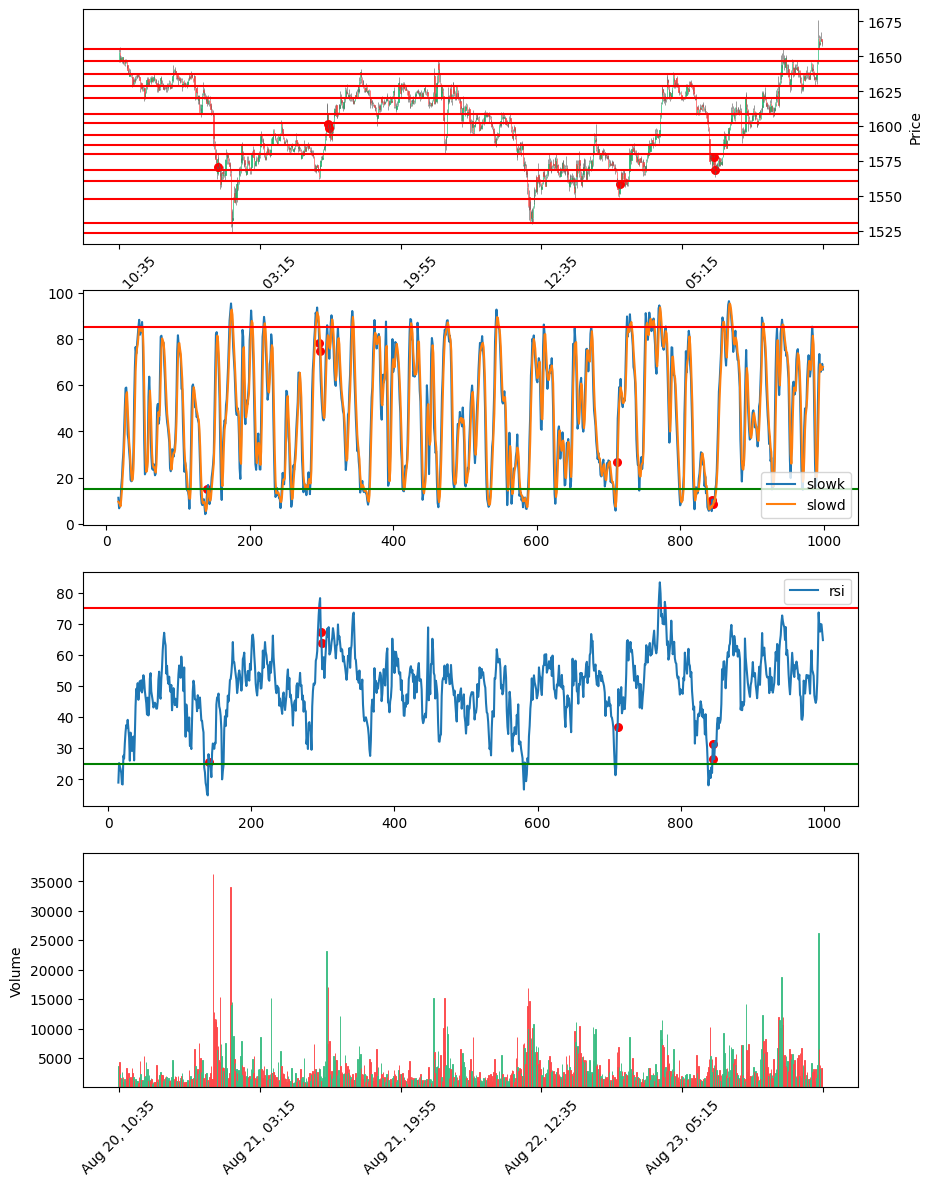

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf

pd.set_option('display.max_rows', 500)

# subplots for STOCH and RSI
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 14))

# plot candles
ohlc = df.loc[:, ['time', 'open', 'high', 'low', 'close', 'volume']]
ohlc = ohlc.set_index('time')
mpf.plot(ohlc, type='candle', ax=ax1, warn_too_much_data=10000, style='yahoo', volume=ax4)

# plot STOCH
ax2.plot(df.loc[:, 'stoch_slowk'])
ax2.plot(df.loc[:, 'stoch_slowd'])
# show bounders
ax2.axhline(y=15, color='g', linestyle='-')
ax2.axhline(y=85, color='r', linestyle='-')
leg = ax2.legend(['slowk', 'slowd'])

# plot RSI
ax3.plot(df.loc[:, 'rsi'])
ax3.axhline(y=25, color='g', linestyle='-')
ax3.axhline(y=75, color='r', linestyle='-')
leg = ax3.legend(['rsi'])

# plot signal points
scatter_candle_points = list()
scatter_stoch_points = list()
scatter_rsi_points = list()

for point in points:
    scatter_candle_points.append((point[0], df.loc[point[0], 'close']))
    scatter_stoch_points.append((point[0], df.loc[point[0], 'stoch_slowk']))
    scatter_rsi_points.append((point[0], df.loc[point[0], 'rsi']))

for point in scatter_candle_points:
#     if 100 < point[0] < 200:
    ax1.scatter(point[0], point[1], s=30, color='red')

for point in scatter_stoch_points:
#     if 100 < point[0] < 200:
    ax2.scatter(point[0], point[1], s=30, color='red')

for point in scatter_rsi_points:
#     if 100 < point[0] < 200:
    ax3.scatter(point[0], point[1], s=30, color='red')

# plot levels
for level in levels:
    # show bounders
    if df.loc[:, 'low'].min() <= level[0] <= df.loc[:, 'high'].max():
        ax1.axhline(y=level[0], color='r', linestyle='-')